In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100


Using TensorFlow backend.


In [2]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, np.newaxis, :, :]


11493376/11490434 [==============================] - 1s 0us/step


In [3]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

# Generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((128, 7, 7)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 14, 14)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 64, 28, 28)        0         
__________

In [4]:
# Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(1, 28, 28), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 14, 14)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 14, 14)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 7, 7)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128, 7, 7)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 7, 7)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
__________

In [0]:
# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [0]:
!mkdir images
dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/dcgan_loss_epoch_%d.png' % epoch)

In [0]:
# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/dcgan_generated_image_epoch_%d.png' % epoch)


  0%|          | 1/468 [00:00<00:47,  9.76it/s]

Epochs: 50
Batch size: 128
Batches per epoch: 468.75
--------------- Epoch 1 ---------------


  0%|          | 2/468 [00:00<00:35, 13.30it/s]

--------------- Epoch 2 ---------------


  0%|          | 2/468 [00:00<00:34, 13.36it/s]

--------------- Epoch 3 ---------------


  0%|          | 2/468 [00:00<00:35, 13.07it/s]

--------------- Epoch 4 ---------------


  0%|          | 2/468 [00:00<00:34, 13.37it/s]

--------------- Epoch 5 ---------------


  0%|          | 2/468 [00:00<00:44, 10.48it/s]

--------------- Epoch 6 ---------------


  0%|          | 2/468 [00:00<00:34, 13.49it/s]

--------------- Epoch 7 ---------------


  0%|          | 2/468 [00:00<00:34, 13.34it/s]

--------------- Epoch 8 ---------------


  0%|          | 2/468 [00:00<00:34, 13.37it/s]

--------------- Epoch 9 ---------------


  0%|          | 2/468 [00:00<00:34, 13.35it/s]

--------------- Epoch 10 ---------------


  0%|          | 2/468 [00:00<00:45, 10.27it/s]

--------------- Epoch 11 ---------------


  0%|          | 2/468 [00:00<00:36, 12.79it/s]

--------------- Epoch 12 ---------------


  0%|          | 2/468 [00:00<00:34, 13.46it/s]

--------------- Epoch 13 ---------------


  0%|          | 2/468 [00:00<00:35, 13.26it/s]

--------------- Epoch 14 ---------------


  0%|          | 2/468 [00:00<00:34, 13.57it/s]

--------------- Epoch 15 ---------------


  0%|          | 2/468 [00:00<00:45, 10.32it/s]

--------------- Epoch 16 ---------------


  0%|          | 2/468 [00:00<00:34, 13.37it/s]

--------------- Epoch 17 ---------------


  0%|          | 2/468 [00:00<00:34, 13.57it/s]

--------------- Epoch 18 ---------------


  0%|          | 2/468 [00:00<00:35, 13.11it/s]

--------------- Epoch 19 ---------------


  0%|          | 2/468 [00:00<00:34, 13.58it/s]

--------------- Epoch 20 ---------------


  0%|          | 2/468 [00:00<00:45, 10.27it/s]

--------------- Epoch 21 ---------------


  0%|          | 2/468 [00:00<00:35, 13.27it/s]

--------------- Epoch 22 ---------------


  0%|          | 2/468 [00:00<00:35, 13.27it/s]

--------------- Epoch 23 ---------------


  0%|          | 2/468 [00:00<00:34, 13.38it/s]

--------------- Epoch 24 ---------------


  0%|          | 2/468 [00:00<00:34, 13.50it/s]

--------------- Epoch 25 ---------------


  0%|          | 2/468 [00:00<00:45, 10.23it/s]

--------------- Epoch 26 ---------------


  0%|          | 2/468 [00:00<00:35, 13.27it/s]

--------------- Epoch 27 ---------------


  0%|          | 2/468 [00:00<00:35, 13.24it/s]

--------------- Epoch 28 ---------------


  0%|          | 2/468 [00:00<00:34, 13.52it/s]

--------------- Epoch 29 ---------------


  0%|          | 2/468 [00:00<00:34, 13.59it/s]

--------------- Epoch 30 ---------------


  0%|          | 1/468 [00:00<00:46,  9.95it/s]

--------------- Epoch 31 ---------------


  0%|          | 2/468 [00:00<00:34, 13.52it/s]

--------------- Epoch 32 ---------------


  0%|          | 2/468 [00:00<00:35, 13.18it/s]

--------------- Epoch 33 ---------------


  0%|          | 2/468 [00:00<00:34, 13.39it/s]

--------------- Epoch 34 ---------------


  0%|          | 2/468 [00:00<00:34, 13.42it/s]

--------------- Epoch 35 ---------------


  0%|          | 1/468 [00:00<00:47,  9.93it/s]

--------------- Epoch 36 ---------------


  0%|          | 2/468 [00:00<00:34, 13.40it/s]

--------------- Epoch 37 ---------------


  0%|          | 2/468 [00:00<00:35, 13.12it/s]

--------------- Epoch 38 ---------------


  0%|          | 2/468 [00:00<00:35, 13.30it/s]

--------------- Epoch 39 ---------------


  0%|          | 2/468 [00:00<00:34, 13.52it/s]

--------------- Epoch 40 ---------------


  0%|          | 2/468 [00:00<00:45, 10.26it/s]

--------------- Epoch 41 ---------------


  0%|          | 2/468 [00:00<00:35, 13.12it/s]

--------------- Epoch 42 ---------------


  0%|          | 2/468 [00:00<00:34, 13.53it/s]

--------------- Epoch 43 ---------------


  0%|          | 2/468 [00:00<00:35, 13.22it/s]

--------------- Epoch 44 ---------------


  0%|          | 2/468 [00:00<00:34, 13.51it/s]

--------------- Epoch 45 ---------------


  0%|          | 1/468 [00:00<00:47,  9.90it/s]

--------------- Epoch 46 ---------------


  0%|          | 2/468 [00:00<00:34, 13.36it/s]

--------------- Epoch 47 ---------------


  0%|          | 2/468 [00:00<00:34, 13.41it/s]

--------------- Epoch 48 ---------------


  0%|          | 2/468 [00:00<00:35, 13.26it/s]

--------------- Epoch 49 ---------------


  0%|          | 2/468 [00:00<00:35, 13.27it/s]

--------------- Epoch 50 ---------------


100%|██████████| 468/468 [00:35<00:00, 13.28it/s]


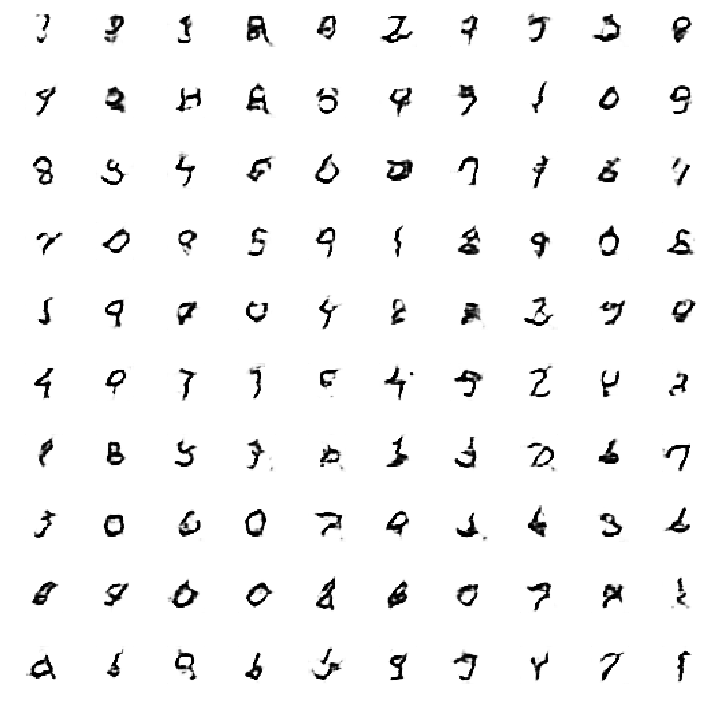

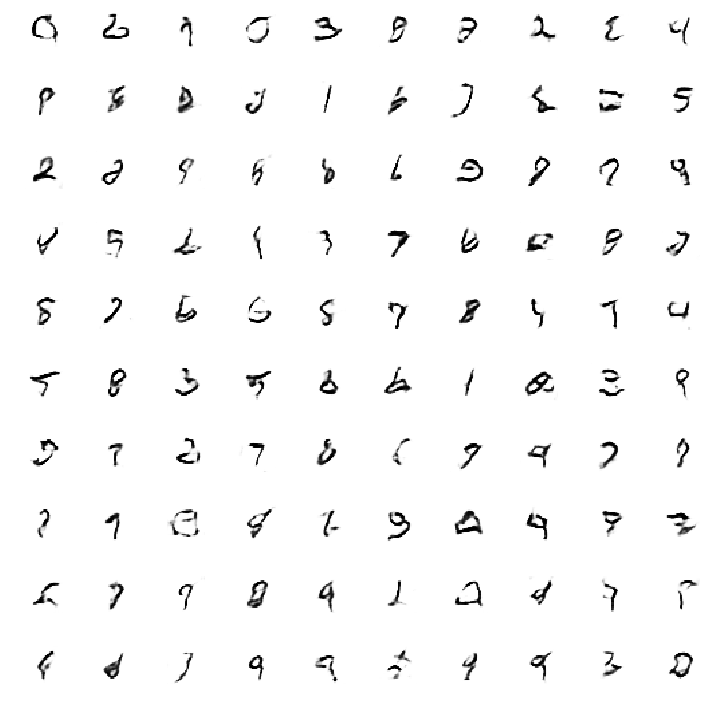

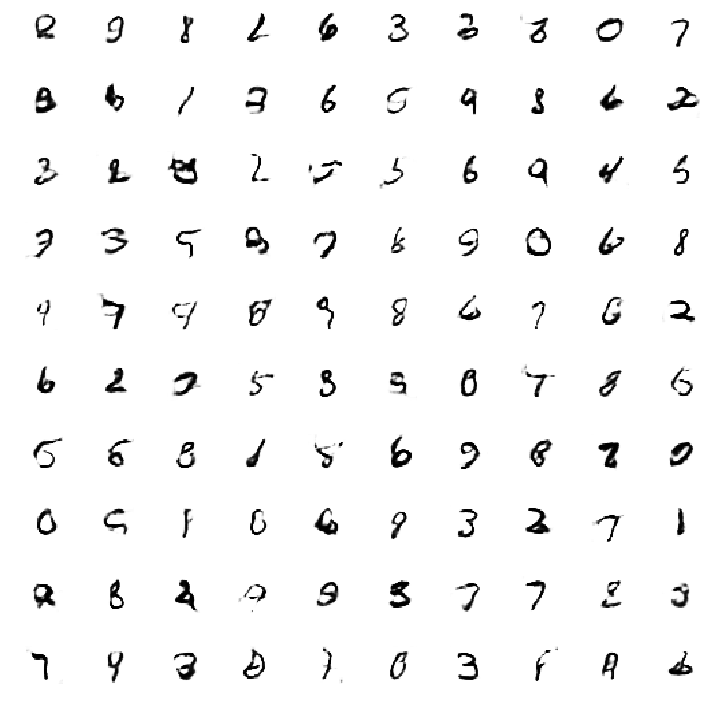

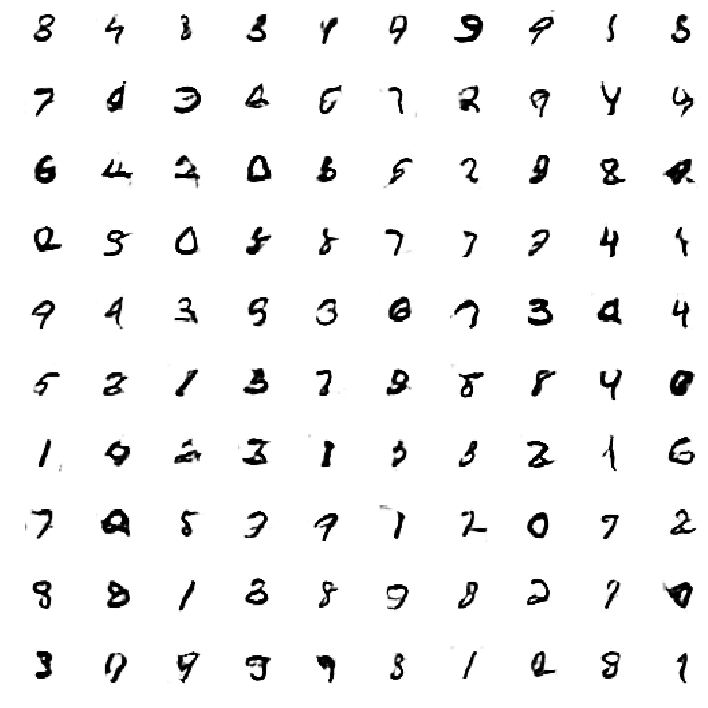

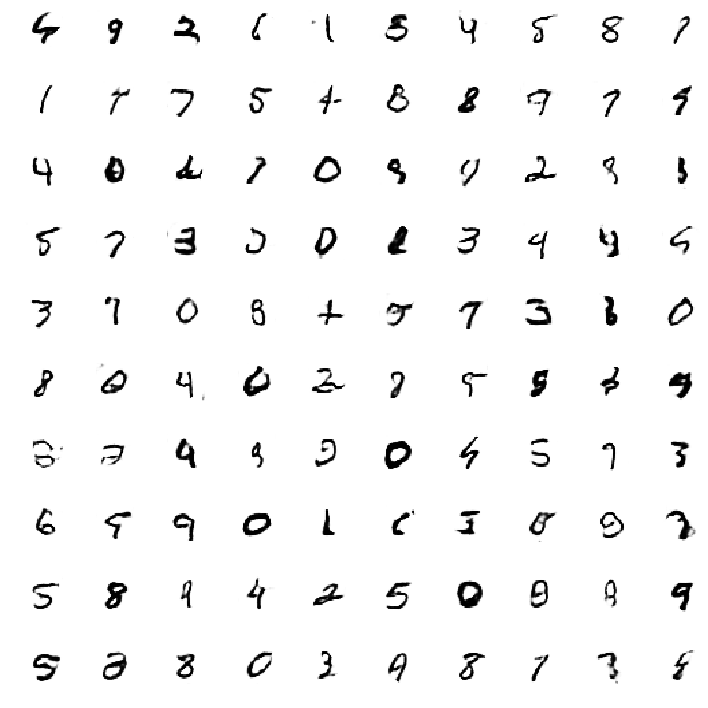

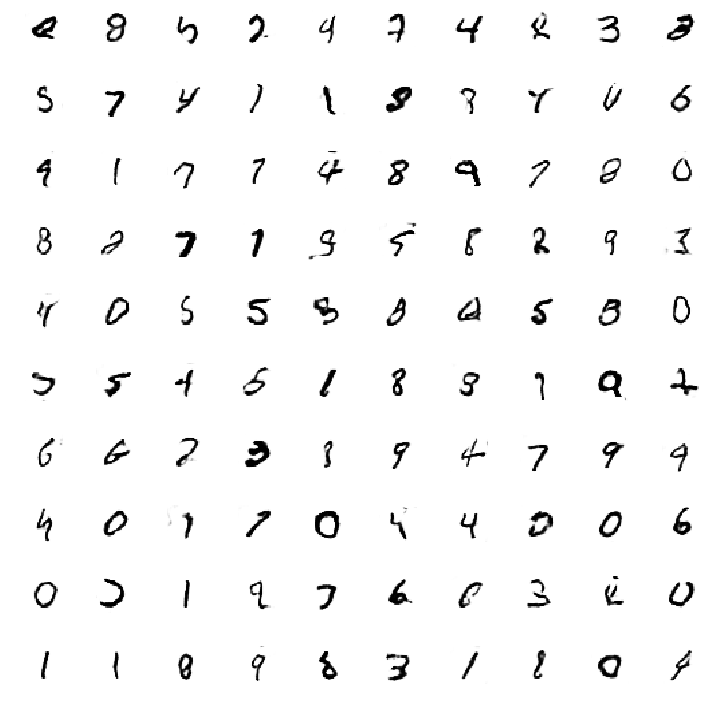

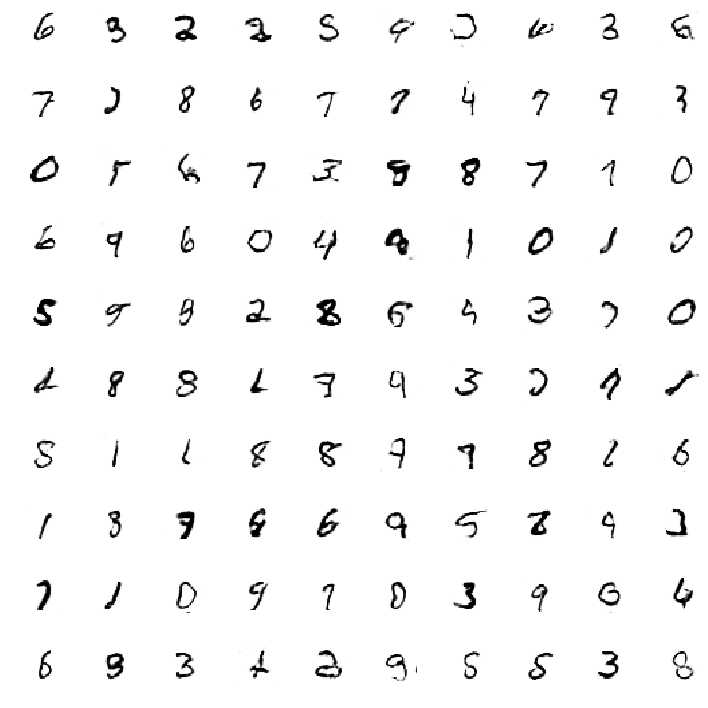

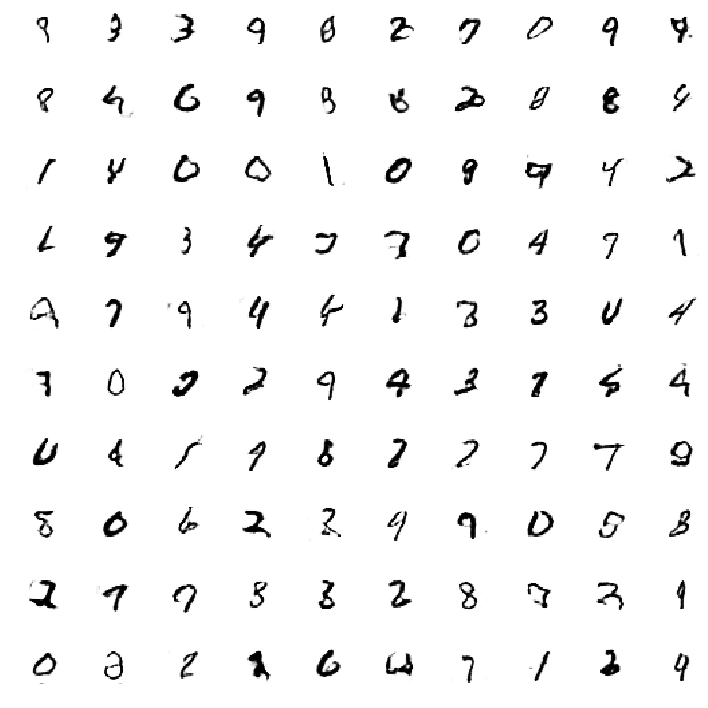

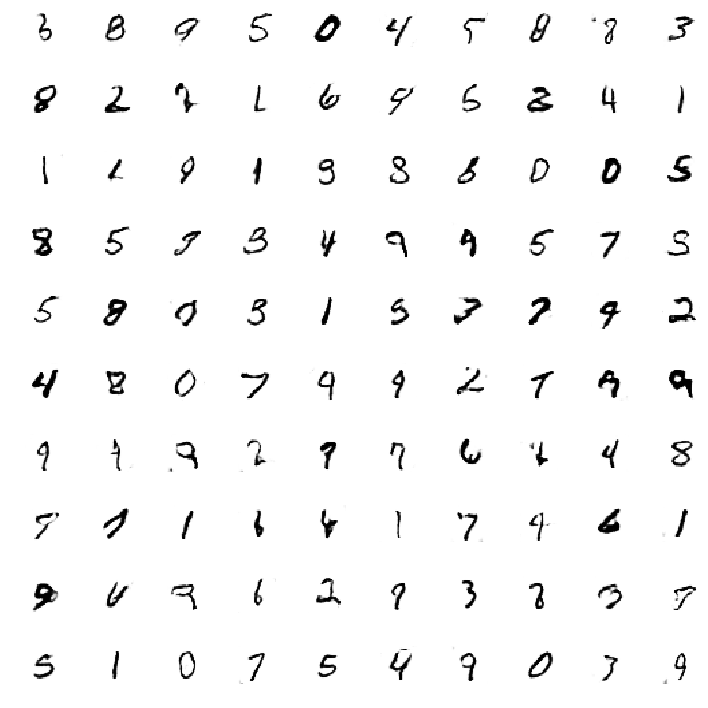

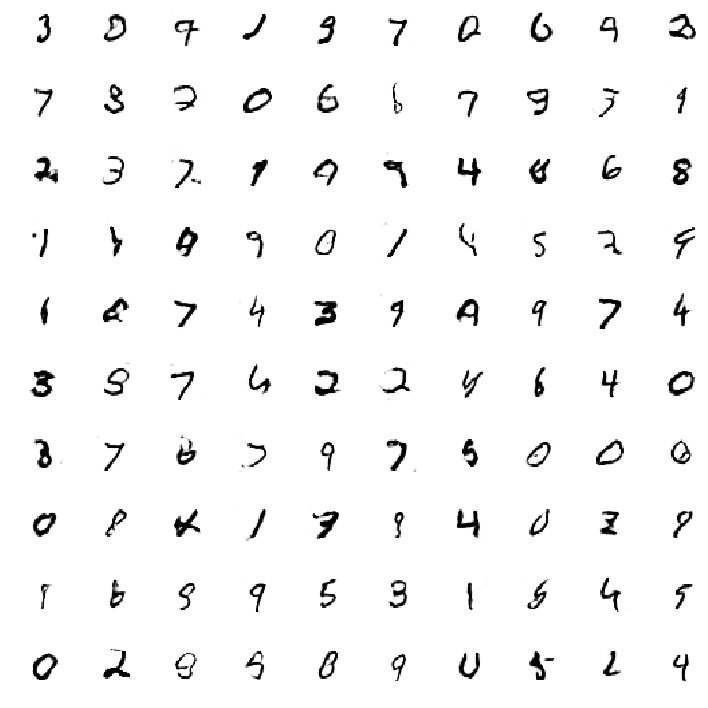

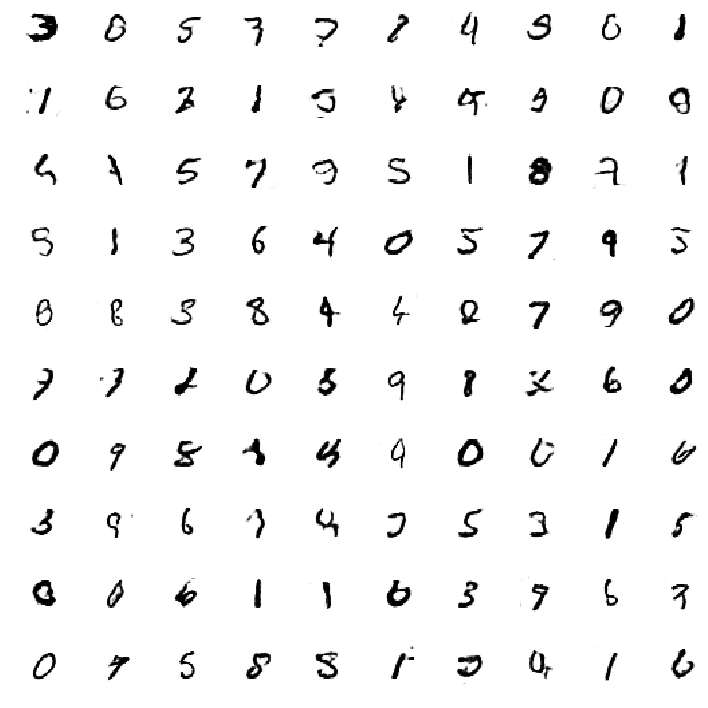

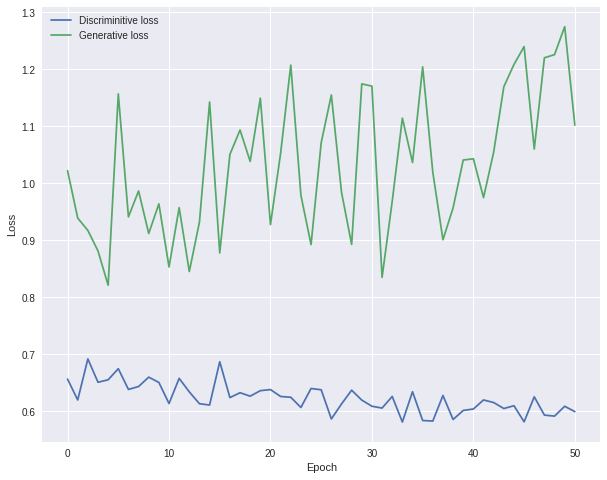

In [16]:
# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('models/dcgan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models/dcgan_discriminator_epoch_%d.h5' % epoch)

def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print('Epochs:', epochs)
    print('Batch size:', batchSize) 
    print('Batches per epoch:', batchCount) 

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batchCount))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 5 == 0:
            plotGeneratedImages(e)
            saveModels(e)

    # Plot losses from every epoch
    plotLoss(e)

if __name__ == '__main__':
    train(50, 128)

 